In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('C:\\Users\\joewa\\Work\\git\\vimms')
sys.path.append('C:\\Users\\Vinny\\work\\vimms')
sys.path.append('..')

In [3]:
import numpy as np
import torch
import random as rand
import pylab as plt
import multiprocessing
from gym import spaces

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_checker import check_env

In [4]:
from vimms.Common import *
from vimms.Gym import VimmsGymEnv
from vimms.Evaluation import evaluate_simulated_env, evaluate_multiple_simulated_env
from vimms.ChemicalSamplers import MZMLFormulaSampler, MZMLRTandIntensitySampler
from vimms.Controller import SimpleTargetController

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [5]:
np.random.seed(0)
rand.seed(0)
torch.manual_seed(0)

# 1. Parameters

In [6]:
set_log_level_warning()

1

In [7]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (0, 300)
# intensity_range = (1E5, 1E10)

In [8]:
# n_chemicals = (500, 2000)
# mz_range = (100, 600)
# rt_range = (200, 1000)
# intensity_range = (1E5, 1E10)

In [9]:
n_chemicals = (200, 500)
mz_range = (100, 600)
rt_range = (200, 1000)
intensity_range = (1E5, 1E10)

In [10]:
min_mz = mz_range[0]
max_mz = mz_range[1]
min_rt = rt_range[0]
max_rt = rt_range[1]
min_log_intensity = np.log(intensity_range[0])
max_log_intensity = np.log(intensity_range[1])

In [11]:
isolation_window = 0.7
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 5000
ionisation_mode = POSITIVE
noise_density = 0.3
noise_max_val = 1e4

In [12]:
in_dim = 50
out_dim = 50

# 2. Define Custom gym

In [13]:
mzml_filename = 'Beer_multibeers_1_fullscan1.mzML'
mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                       min_log_intensity=min_log_intensity,
                                       max_log_intensity=max_log_intensity)

In [14]:
params = {
    'chemical_creator': {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
    },
    'noise': {
        'noise_density': noise_density,
        'noise_max_val': noise_max_val,
        'mz_range': mz_range
    },
    'env': {
        'ionisation_mode': ionisation_mode,
        'rt_range': rt_range,
        'N': N,
        'isolation_window': isolation_window,
        'mz_tol': mz_tol,
        'rt_tol': rt_tol,
        'min_ms1_intensity': min_ms1_intensity
    }
}

In [15]:
class MaxIntensityEnv(VimmsGymEnv):
    def __init__(self, in_dim, out_dim, params):
        super().__init__(in_dim, out_dim, params)  
        self.last_excluded = []
        self.selected_precursors = []
    
    def _get_action_space(self):
        """
        Defines action space
        """
        return spaces.MultiBinary(self.out_dim)

    def _get_observation_space(self):
        """
        Defines observation space
        """
        intensity_high = np.log(intensity_range[1]) + 10
        features = {
            'intensity': spaces.Box(low=0.0, high=intensity_high, shape=(self.in_dim,)),
            'exclusion': spaces.Box(low=0.0, high=1.0, shape=(self.in_dim,))
        }
        return spaces.Dict(features)
    
    def _get_state(self, scan_to_process):
        """
        Converts a scan to a state
        """
        self.last_scan_to_process = scan_to_process        
        mzs, rt, intensities = self._get_mzs_rt_intensities(scan_to_process)
        
        precursors = []
        self.last_excluded = []
        for mz, intensity in zip(mzs, intensities):
            if self.controller.exclusion.is_excluded(mz, rt):
                excluded = 0
                self.last_excluded.append((mz, rt, intensity, ))                
            else:
                excluded = 1
            precursor = (mz, intensity, excluded, )
            precursors.append(precursor)                
        
        sorted_precursors = sorted(precursors, key=lambda item: item[1], reverse=True) # sort by intensity descending
        self.selected_precursors = []        
        feature_intensity = []
        feature_exclusion = []
        for i in range(self.in_dim): # get the first in_dim items
            precursor = sorted_precursors[i]
            mz, intensity, excluded = precursor            
            self.selected_precursors.append(precursor)
            
            intensity = np.log(intensity)
            if np.isnan(intensity):
                intensity = 0
            feature_intensity.append(intensity)
            feature_exclusion.append(excluded)
            
        feature_intensity = np.array(feature_intensity)
        feature_exclusion = np.array(feature_exclusion)
        features = {
            'intensity': feature_intensity,
            'exclusion': feature_exclusion
        }
        return features
    
    def _compute_reward(self, scan_to_process, results):
        """
        Computes fragmentation reward
        """
        parent_scan_id = self.controller.last_ms1_scan.scan_id
        assert scan_to_process.scan_id == parent_scan_id
    
        total_reward = 0.0
        for last_scan in results:
            if last_scan.ms_level >= 2:                
                precursor = last_scan.scan_params.get(ScanParameters.PRECURSOR_MZ)[0]
                mz = precursor.precursor_mz
                frag_rt = last_scan.scan_params.get(ScanParameters.METADATA)['frag_at']
                intensity = precursor.precursor_intensity
                
                # intensity reward
                reward = np.log(intensity)
                
                # time reward
                time_filter = 0 if (mz, frag_rt, intensity, ) in self.last_excluded else 1
                reward = reward * time_filter
                
                total_reward += reward
        return total_reward    

    def _take_action(self, action):
        """
        Modify controller variables based on the selected action
        """
        target_flag = action      
        assert len(target_flag) == len(self.selected_precursors)
        
        targets = []
        for i in range(len(target_flag)):
            t = target_flag[i]
            if t == 1:
                mz, intensity, excluded = self.selected_precursors[i]
                targets.append((mz, intensity))
                
        # self.seen_actions.update(['targets=%s' % targets])
        self.controller.targets = targets
        
    def _reset_controller(self, env_params):
        """
        Generates new controller
        """
        ionisation_mode = env_params['ionisation_mode']
        N = env_params['N']
        isolation_window = env_params['isolation_window']
        mz_tol = env_params['mz_tol']
        rt_tol = env_params['rt_tol']
        min_ms1_intensity = env_params['min_ms1_intensity']
        controller = SimpleTargetController(ionisation_mode, N, isolation_window, mz_tol, rt_tol, min_ms1_intensity)
        return controller

In [16]:
set_log_level_info()

2

# 3. Training

### PPO

In [17]:
env = MaxIntensityEnv(in_dim, out_dim, params)
check_env(env)

#### Multiprocessing

In [18]:
from typing import Callable

def make_env(rank, seed=0):
    def _init():
        env = MaxIntensityEnv(in_dim, out_dim, params)
        env.seed(rank)
        return env
    set_random_seed(seed)
    return _init

num_cpu = multiprocessing.cpu_count()
num_cpu

24

In [19]:
env = SubprocVecEnv([make_env(i) for i in range(num_cpu)]) 

#### Training

In [20]:
model_name = 'PPO'
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log='./results/%s_MaxIntensityEnv_tensorboard' % model_name)
model.learn(total_timesteps=10000000)

Using cpu device
Logging to ./results/PPO_MaxIntensityEnv_tensorboard/PPO_1
------------------------------
| time/              |       |
|    fps             | 32    |
|    iterations      | 1     |
|    time_elapsed    | 1515  |
|    total_timesteps | 49152 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 2           |
|    time_elapsed         | 3251        |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.006192386 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -34.7       |
|    explained_variance   | -8.55e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.48e+06    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00417    |
|    value_loss           | 7.83e+0

In [21]:
fname = 'results/%s_maxintensity_smallchems' % model_name
model.save(fname)

# 4. Evaluation

Load previously trained model

In [22]:
model_name = 'PPO'
fname = 'results/%s_maxintensity_smallchems' % model_name
model = PPO.load(fname)

In [23]:
num_episodes = 20
write_mzml_every = 5
N = 10

Generate some evaluation chemicals

In [24]:
chems_list = []
for i in range(num_episodes):
    env = MaxIntensityEnv(in_dim, out_dim, params)
    env.reset()
    chems = env.chems
    print(len(chems))
    chems_list.append(chems)

397
415
220
332
461
448
407
355
444
383
498
311
458
271
344
271
248
328
472
275


Do a few topN steps manually

In [25]:
def topN(observation, N=10, min_ms1_intensity=5000):
    intensities = observation['intensity']
    exclusions = observation['exclusion']
    log_min_ms1_intensity = np.log(min_ms1_intensity)
    
    action = []
    count = 0
    for i in range(len(intensities)):
        intensity, exclusion = intensities[i], exclusions[i]
        if count < N:
            if exclusion == 1 and intensity > log_min_ms1_intensity:
                action.append(1)
                count += 1
            else:
                action.append(0)
        else:
            action.append(0)
    action = np.array(action)
    return action

In [26]:
env = MaxIntensityEnv(in_dim, out_dim, params)
chems = chems_list[0]
observation = env.reset(chems=chems)
observation

{'intensity': array([9.20153285, 9.20137736, 9.19947962, 9.19008858, 9.18693708,
        9.18476743, 9.18463763, 9.18381777, 9.18374006, 9.17745463,
        9.16538246, 9.16451446, 9.16392957, 9.16319888, 9.15826749,
        9.15482537, 9.15164406, 9.14958874, 9.14859345, 9.13177399,
        9.13078332, 9.1262732 , 9.12009567, 9.10934588, 9.1065432 ,
        9.09119903, 9.09054469, 9.0894166 , 9.08318108, 9.07638756,
        9.07227025, 9.06901673, 9.06284648, 9.05806259, 9.05476749,
        9.04174648, 9.02808551, 9.02673903, 8.98779786, 8.98657412,
        8.9720677 , 8.96937501, 8.96393486, 8.94926702, 8.94207376,
        8.89733023, 8.89619552, 8.88620742, 8.87611662, 8.8505079 ]),
 'exclusion': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])}

In [27]:
for i in range(10):
    action = topN(observation, N=N, min_ms1_intensity=min_ms1_intensity)
    observation, reward, done, info = env.step(action)
    action, reward, observation, done
    print('step %d' % i)
    print('action = %s' % action)
    print('reward = %f' % reward)
    print('done = %s' % done)    
    print('next observation = %s' % observation)
    print()

step 0
action = [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
reward = 91.893833
done = False
next observation = {'intensity': array([9.50214253, 9.45106773, 9.20266241, 9.20222991, 9.2015819 ,
       9.19848281, 9.19723551, 9.1804736 , 9.16137788, 9.15479496,
       9.15429437, 9.14847605, 9.14499637, 9.13450964, 9.12897839,
       9.12710313, 9.1256446 , 9.11995126, 9.10839415, 9.09071864,
       9.07928683, 9.07526695, 9.06826999, 9.06704062, 9.04140201,
       9.03658004, 9.02836276, 9.02517541, 9.01776072, 9.0131476 ,
       9.00383811, 9.00147973, 8.98216516, 8.97972641, 8.97807447,
       8.93425935, 8.9302945 , 8.91565316, 8.90399737, 8.90260123,
       8.90010991, 8.88622689, 8.88031787, 8.87308047, 8.87278163,
       8.85499037, 8.85259269, 8.85222155, 8.84453978, 8.83764074]), 'exclusion': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Compute evaluation here

In [28]:
def evaluation(model, model_name, in_dim, out_dim, params, num_episodes, chems_list):
    env = MaxIntensityEnv(in_dim, out_dim, params)
    total_rewards = []
    total_reward_per_chems = []
    env_list = []
    
    for i_episode in range(num_episodes):
        chems = chems_list[i_episode]
        observation = env.reset(chems=chems)
        total_reward = 0
        for t in range(1000):
            # env.render()
            if model_name == 'random':
                action = env.action_space.sample()
                out_file = 'test_%s_%d.mzML' % ('random', i_episode)
            elif model_name == 'TopN':
                action = topN(observation, N=N, min_ms1_intensity=min_ms1_intensity)
                out_file = 'test_%s_%d.mzML' % ('TopN', i_episode)                
            else:
                action, _ = model.predict(observation, deterministic=True)     
                out_file = 'test_%s_%d.mzML' % (model_name, i_episode)
                                                
            observation, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                seen_actions = env.seen_actions.most_common()
                n_chems = len(env.chems)
                reward_per_chems = total_reward / n_chems
                total_rewards.append(total_reward)
                total_reward_per_chems.append(reward_per_chems)
                env_list.append(env.vimms_env)
                if i_episode % write_mzml_every == 0 or i_episode == num_episodes-1:
                    env.vimms_env.write_mzML('results', out_file)
                print('Episode %d timesteps %d reward %f n_chems %d reward/chems %f' % (i_episode, t+1, total_reward, n_chems, reward_per_chems))                                        
                break
    env.close()
    print('Average total reward = %f' % np.mean(total_rewards))
    return np.array(total_rewards), np.array(total_reward_per_chems), env_list

In [29]:
model_total_rewards, model_reward_per_chems, model_env_list = evaluation(model, model_name, in_dim, out_dim, params, num_episodes, chems_list)

Episode 0 timesteps 118 reward 29750.887009 n_chems 397 reward/chems 74.939262
Episode 1 timesteps 118 reward 28892.199722 n_chems 415 reward/chems 69.619758
Episode 2 timesteps 118 reward 32700.225362 n_chems 220 reward/chems 148.637388
Episode 3 timesteps 118 reward 30478.787246 n_chems 332 reward/chems 91.803576
Episode 4 timesteps 118 reward 27957.996079 n_chems 461 reward/chems 60.646412
Episode 5 timesteps 118 reward 28247.026013 n_chems 448 reward/chems 63.051397
Episode 6 timesteps 118 reward 29435.608072 n_chems 407 reward/chems 72.323361
Episode 7 timesteps 118 reward 30215.360090 n_chems 355 reward/chems 85.113690
Episode 8 timesteps 118 reward 28149.660461 n_chems 444 reward/chems 63.400136
Episode 9 timesteps 118 reward 29920.876395 n_chems 383 reward/chems 78.122393
Episode 10 timesteps 118 reward 26937.170061 n_chems 498 reward/chems 54.090703
Episode 11 timesteps 118 reward 31447.713954 n_chems 311 reward/chems 101.118051
Episode 12 timesteps 118 reward 28135.836794 n_c

In [30]:
topN_total_rewards, topN_reward_per_chems, topN_env_list = evaluation(None, 'TopN', in_dim, out_dim, params, num_episodes, chems_list)

Episode 0 timesteps 334 reward 39195.354238 n_chems 397 reward/chems 98.728852
Episode 1 timesteps 334 reward 40006.937202 n_chems 415 reward/chems 96.402258
Episode 2 timesteps 334 reward 35448.656927 n_chems 220 reward/chems 161.130259
Episode 3 timesteps 334 reward 37852.008824 n_chems 332 reward/chems 114.012075
Episode 4 timesteps 334 reward 40860.173619 n_chems 461 reward/chems 88.633782
Episode 5 timesteps 334 reward 40598.085123 n_chems 448 reward/chems 90.620726
Episode 6 timesteps 334 reward 39700.763776 n_chems 407 reward/chems 97.544874
Episode 7 timesteps 334 reward 38304.218843 n_chems 355 reward/chems 107.899208
Episode 8 timesteps 334 reward 40884.733569 n_chems 444 reward/chems 92.082733
Episode 9 timesteps 334 reward 38906.820454 n_chems 383 reward/chems 101.584388
Episode 10 timesteps 334 reward 41571.145209 n_chems 498 reward/chems 83.476195
Episode 11 timesteps 334 reward 37487.627188 n_chems 311 reward/chems 120.538994
Episode 12 timesteps 334 reward 40494.634906 

In [31]:
random_total_rewards, random_reward_per_chems, random_env_list = evaluation(None, 'random', in_dim, out_dim, params, num_episodes, chems_list)

Episode 0 timesteps 148 reward 26474.534165 n_chems 397 reward/chems 66.686484
Episode 1 timesteps 148 reward 26380.269552 n_chems 415 reward/chems 63.566915
Episode 2 timesteps 148 reward 30029.176660 n_chems 220 reward/chems 136.496258
Episode 3 timesteps 151 reward 28263.031236 n_chems 332 reward/chems 85.129612
Episode 4 timesteps 150 reward 26126.734322 n_chems 461 reward/chems 56.674044
Episode 5 timesteps 154 reward 25933.681288 n_chems 448 reward/chems 57.887681
Episode 6 timesteps 149 reward 27249.227091 n_chems 407 reward/chems 66.951418
Episode 7 timesteps 149 reward 27883.018507 n_chems 355 reward/chems 78.543714
Episode 8 timesteps 146 reward 26345.849105 n_chems 444 reward/chems 59.337498
Episode 9 timesteps 148 reward 27506.414085 n_chems 383 reward/chems 71.818314
Episode 10 timesteps 149 reward 26108.816631 n_chems 498 reward/chems 52.427343
Episode 11 timesteps 151 reward 28077.400166 n_chems 311 reward/chems 90.281029
Episode 12 timesteps 149 reward 25614.788916 n_ch

### Plots

In [32]:
def plot_diff(controller_names, scores_list, ref_name, ref_scores):
    for controller_name, scores in zip(controller_names, scores_list):
        diff = scores - ref_scores
        perc = np.multiply(diff, 1/ref_scores) * 100
        plt.plot(diff, label=controller_name)
    plt.title('Score improvement over %s' % ref_name)
    plt.ylabel('Score Improvement (%)')
    plt.xlabel('Episode')        
    plt.legend()

def plot_arr(controller_names, arr_list, title):
    for controller_name, arr in zip(controller_names, arr_list):
        plt.plot(arr, label=controller_name)
    plt.title('%s per Episode' % title)
    plt.ylabel(title)
    plt.xlabel('Episode')        
    plt.legend()
        
def get_scores(env_list, type='both'):
    scores = []
    for env in env_list:
        score = get_score(env, type=type)
        scores.append(score)
    return np.array(scores)

def get_score(env, type='both'):
    res = evaluate_simulated_env(env)
    if type == 'both':
        score = res['coverage_proportion'] * res['intensity_proportion']
    elif type == 'coverage':
        score = res['coverage_proportion']    
    elif type == 'intensity':
        score = res['intensity_proportion']    
    return score

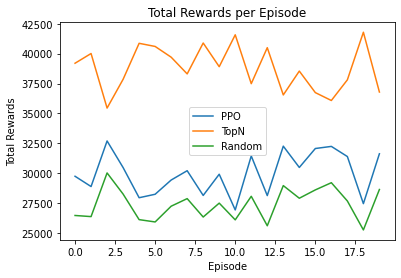

In [33]:
plot_arr([model_name, 'TopN', 'Random'], [model_total_rewards, topN_total_rewards, random_total_rewards], 'Total Rewards')

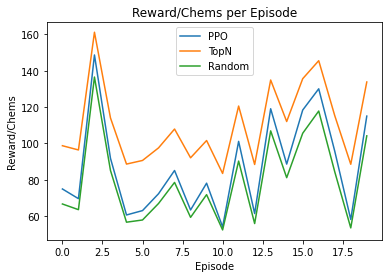

In [34]:
plot_arr([model_name, 'TopN', 'Random'], [model_reward_per_chems, topN_reward_per_chems, random_reward_per_chems], 'Reward/Chems')

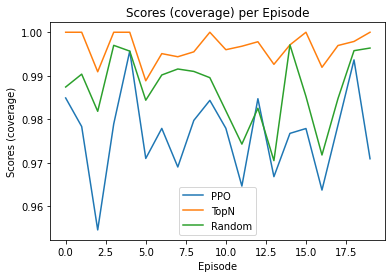

In [35]:
score_type = 'coverage'
model_scores = get_scores(model_env_list, type=score_type)
topN_scores = get_scores(topN_env_list, type=score_type)
random_scores = get_scores(random_env_list, type=score_type)
plot_arr([model_name, 'TopN', 'Random'], [model_scores, topN_scores, random_scores], 'Scores (coverage)')

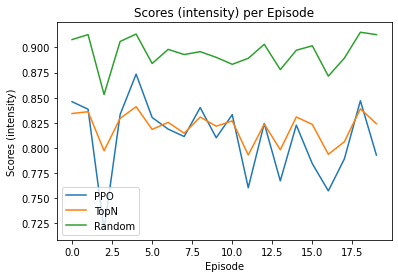

In [36]:
score_type = 'intensity'
model_scores = get_scores(model_env_list, type=score_type)
topN_scores = get_scores(topN_env_list, type=score_type)
random_scores = get_scores(random_env_list, type=score_type)
plot_arr([model_name, 'TopN', 'Random'], [model_scores, topN_scores, random_scores], 'Scores (intensity)')